In [1]:
%load_ext autoreload
%autoreload 2

import warnings
from rasterio.errors import NotGeoreferencedWarning

warnings.filterwarnings("ignore", category=NotGeoreferencedWarning)

In this notebook you will learn how to get started with PytorchEO training a baseline model for the [Solar Panel Detection Using Sentinel-2](https://solafune.com/competitions/5dfc315c-1b24-4573-804f-7de8d707cd90) challenge.

## Data exploration

Before continuing, join the challenge, download and extract the [data](https://solafune.com/competitions/5dfc315c-1b24-4573-804f-7de8d707cd90?menu=data&tab=).

In [2]:
import os 
from pathlib import Path

path = Path('/fastdata/solarPanelDetection/') # path to the data 
folders = [f for f in os.listdir(path) if os.path.isdir(path / f)] # get all the folders in the path
folders

['evaluation', 'train', 'sample']

The train folder contains images and masks for training

In [3]:
os.listdir(path / 'train') 

['s2_image', 'mask']

In [4]:
from glob import glob

images = glob(str(path / 'train' / 's2_image/*.tif'))
masks = glob(str(path / 'train' / 'mask/*.tif'))

len(images), len(masks)

(2066, 2066)

In [5]:
images[:3], masks[:3]

(['/fastdata/solarPanelDetection/train/s2_image/train_s2_image_2037.tif',
  '/fastdata/solarPanelDetection/train/s2_image/train_s2_image_792.tif',
  '/fastdata/solarPanelDetection/train/s2_image/train_s2_image_1118.tif'],
 ['/fastdata/solarPanelDetection/train/mask/train_mask_539.tif',
  '/fastdata/solarPanelDetection/train/mask/train_mask_801.tif',
  '/fastdata/solarPanelDetection/train/mask/train_mask_157.tif'])

In [6]:
# generate list of image ids 

ids = [f.split('_')[-1][:-4] for f in images]
len(ids), ids[:3]

(2066, ['2037', '792', '1118'])

We can visualize some samples

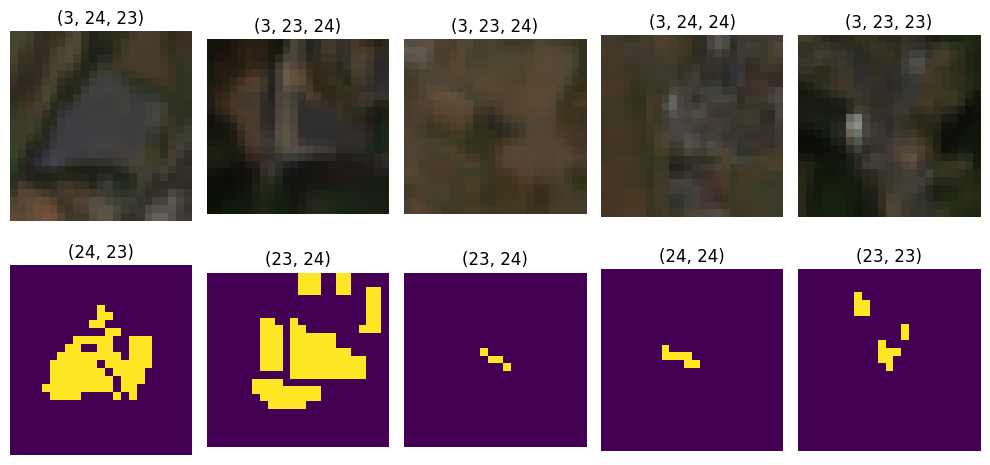

In [10]:
import matplotlib.pyplot as plt
import rasterio as rio 
import random

cols = 5
fig = plt.figure(figsize=(cols*2, 5))
for col in range(cols):
	image_id = random.choice(ids)
	ax1 = fig.add_subplot(2, cols, col+1)
	image_path = path / 'train' / 's2_image' / f'train_s2_image_{image_id}.tif'
	ds = rio.open(image_path)
	rgb = ds.read((4,3,2)) / 4000 
	ax1.imshow(rgb.transpose(1,2,0))
	ax1.axis('off')
	ax1.set_title(rgb.shape)
	ax2 = fig.add_subplot(2, cols, col+cols+1)
	mask_path = path / 'train' / 'mask' / f'train_mask_{image_id}.tif'
	mask = rio.open(mask_path).read(1)
	ax2.imshow(mask)
	ax2.axis('off')
	ax2.set_title(mask.shape)
plt.tight_layout()
plt.show()

Images are very small and can have different size. Masks are binary.

In [11]:
rgb.dtype, mask.dtype, mask.min(), mask.max()

(dtype('float64'), dtype('uint8'), 0, 1)

In [12]:
shapes = {}
for image in images:
	x = rio.open(image).read().shape
	shapes[x] = shapes.get(x, 0) + 1
shapes

{(12, 23, 24): 283,
 (12, 23, 23): 914,
 (12, 25, 25): 72,
 (12, 24, 24): 359,
 (12, 24, 23): 339,
 (12, 22, 22): 4,
 (12, 23, 22): 26,
 (12, 25, 24): 27,
 (12, 22, 23): 20,
 (12, 24, 25): 16,
 (12, 26, 25): 2,
 (12, 25, 26): 3,
 (12, 26, 26): 1}

The evaluation folder contains the images for generating the submission masks (which an examples is given in the samples folder).

In [13]:
test_images = os.listdir(path / 'evaluation')
len(test_images), test_images[:3]

(2066,
 ['evaluation_s2_image_851.tif',
  'evaluation_s2_image_1695.tif',
  'evaluation_s2_image_1204.tif'])

In [14]:
test_masks = os.listdir(path / 'sample')
len(test_masks), test_masks[:3]

(2066,
 ['evaluation_mask_1646.tif',
  'evaluation_mask_859.tif',
  'evaluation_mask_1261.tif'])

## The Dataset

PytorchEO is built around `Datasets` and `Tasks`. In this challenge we are asked to solve an image segmentation task with a dataset composed of Sentinel 2 images with corresponding solar panels masks. 

You can build your own PytorchEO Dataset as follows:


In [15]:
# imports
import lightning as L
import pandas as pd
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
import numpy as np
from einops import rearrange
import albumentations as A
from albumentations.pytorch import ToTensorV2
from pathlib import Path
from glob import glob
import os

# Pytorch EO imports
from pytorch_eo.datasets import ConcatDataset
from pytorch_eo.datasets.sensors import S2
from pytorch_eo.datasets.sensors import Sensors
from pytorch_eo.datasets import SensorImageDataset, RGBImageDataset

class Dataset(L.LightningDataModule): 

    def __init__(self,
                 batch_size=32,
                 path='/fastdata/solarPanelDetection/', 
                 val_size=0.2,
                 train_trans=[],
                 val_trans=[],
                 num_workers=0,
                 pin_memory=False,
                 seed=42,
                 verbose=False,
                 bands=None,
                 ):
        super().__init__()
        self.path = Path(path)
        self.batch_size = batch_size
        self.val_size = val_size
        self.train_trans = self.setup_trans(train_trans)
        self.val_trans = self.setup_trans(val_trans)
        self.bands = bands if bands is not None else S2.RGB
        self.num_bands = (
            len(self.bands)
            if isinstance(self.bands, list)
            else len(self.bands.value)
            if isinstance(self.bands.value, list)
            else 1
        )
        self.num_classes = 1
        self.num_workers = num_workers
        self.pin_memory = pin_memory
        self.seed = seed
        self.verbose = verbose

    def setup(self, stage=None):
        # generate image and masks paths for training
        images = glob(str(self.path / 'train' / 's2_image/*.tif'))
        ids = [f.split('_')[-1][:-4] for f in images]
        masks = [str(self.path / 'train' / 'mask' / f'train_mask_{id}.tif') for id in ids]
        _masks = glob(str(self.path / 'train' / 'mask/*.tif'))
        assert len(images) == len(masks) == len(_masks) == len(ids) == 2066, 'number of training images and masks must be 2066'
        for mask in masks:
            assert mask in _masks, f'{mask} not found'
        # generate test image paths
        test_images = glob(str(self.path / 'evaluation/*.tif'))
        test_ids = [f.split('_')[-1][:-4] for f in test_images]
        assert len(test_images) == len(test_ids) == 2066, 'number of test images must be 100'
        # build dataframe and splits
        self.df = pd.DataFrame({'image': images, 'mask': masks})
        self.train_df, self.val_df = self.df, None
        if self.val_size > 0:
            self.train_df, self.val_df = train_test_split(
                self.df,
                test_size=int(len(self.df) * self.val_size),
                random_state=self.seed,
            )
        if self.verbose:
            print("Training samples", len(self.train_df))
            if self.val_df is not None:
                print("Validation samples", len(self.val_df))
        self.test_df = pd.DataFrame({'image': test_images, 'id': test_ids})
        # generate datasets
        self.train_ds = self.get_dataset(self.train_df, self.train_trans)
        self.val_ds = (
            self.get_dataset(self.val_df, self.val_trans)
            if self.val_df is not None
            else None
        )
        
    def get_dataset(self, df, trans=None):
        return ConcatDataset({ # In PytorchEO you can leverage low-level Pytorch Datasets to build your own dataset
            'image': SensorImageDataset(df.image.values, Sensors.S2, self.bands),
            'mask': RGBImageDataset(df['mask'].values)
        }, trans)
    
    def get_dataloader(self, ds, batch_size=None, shuffle=False):
        return DataLoader(
            ds,
            batch_size=self.batch_size if batch_size is None else batch_size,
            num_workers=self.num_workers,
            pin_memory=self.pin_memory,
            shuffle=shuffle,
        )

    def train_dataloader(self, batch_size=None, shuffle=True):
        return self.get_dataloader(self.train_ds, batch_size, shuffle)

    def val_dataloader(self, batch_size=None, shuffle=False):
        return (
            self.get_dataloader(self.val_ds, batch_size, shuffle)
            if self.val_ds is not None
            else None
        )
    
    def setup_trans(self, trans):
        def clip(x, **kwargs):
            return np.clip(x, 0.0, 1.0).astype(np.float32)
        def normalize(x, **kwargs):
            return x / 4000 if x.ndim == 3 else (x > 0.5).astype(np.uint8)
        return A.Compose(
            trans + [
                A.Resize(32, 32), # resize to 32x32 due to model architecture
                A.Lambda(image=normalize), 
                A.Lambda(image=clip), 
                ToTensorV2(),  
            ], 
            additional_targets={"mask": "image"}, 
            is_check_shapes=False) # original images and masks can have different shapes
        


In [16]:
ds = Dataset(batch_size=5)
ds.setup()

In [18]:
ds.df # dataframe with image and mask paths

,image,mask
0,/fastdata/solarPanelDetection/train/s2_image/t...,/fastdata/solarPanelDetection/train/mask/train...
1,/fastdata/solarPanelDetection/train/s2_image/t...,/fastdata/solarPanelDetection/train/mask/train...
2,/fastdata/solarPanelDetection/train/s2_image/t...,/fastdata/solarPanelDetection/train/mask/train...
3,/fastdata/solarPanelDetection/train/s2_image/t...,/fastdata/solarPanelDetection/train/mask/train...
4,/fastdata/solarPanelDetection/train/s2_image/t...,/fastdata/solarPanelDetection/train/mask/train...
...,...,...
2061,/fastdata/solarPanelDetection/train/s2_image/t...,/fastdata/solarPanelDetection/train/mask/train...
2062,/fastdata/solarPanelDetection/train/s2_image/t...,/fastdata/solarPanelDetection/train/mask/train...
2063,/fastdata/solarPanelDetection/train/s2_image/t...,/fastdata/solarPanelDetection/train/mask/train...
2064,/fastdata/solarPanelDetection/train/s2_image/t...,/fastdata/solarPanelDetection/train/mask/train...


In [19]:
batch = next(iter(ds.train_dataloader()))

images, masks = batch['image'], batch['mask']
images.shape, masks.shape, images.dtype, masks.dtype, images.max(), masks.max(), images.min(), masks.min()

(torch.Size([5, 3, 32, 32]),
 torch.Size([5, 1, 32, 32]),
 torch.float32,
 torch.float32,
 tensor(0.5619),
 tensor(1.),
 tensor(0.0370),
 tensor(0.))

Let's visualize again some training samples

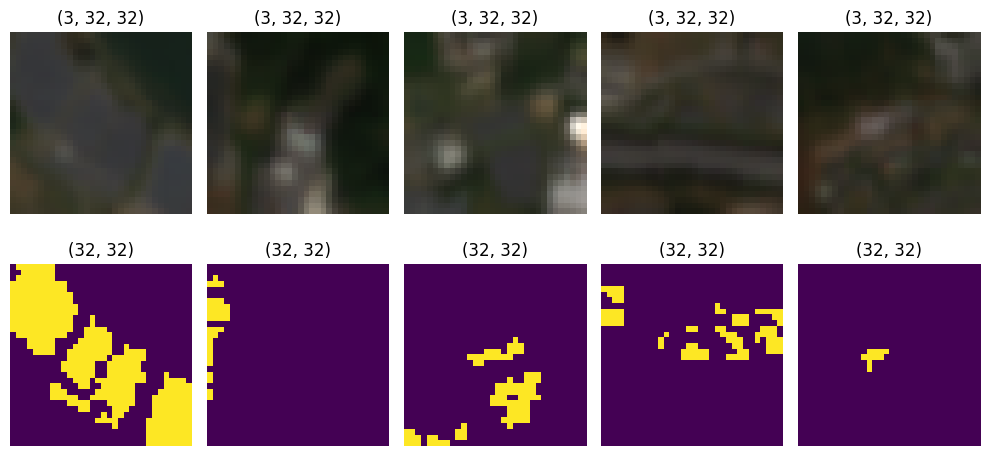

In [21]:
import matplotlib.pyplot as plt

batch = next(iter(ds.train_dataloader()))
images, masks = batch['image'], batch['mask']
cols = 5
fig = plt.figure(figsize=(cols*2, 5))
for col in range(cols):
	ax1 = fig.add_subplot(2, cols, col+1)
	image = images[col].numpy()
	ax1.imshow(image.transpose(1,2,0))
	ax1.axis('off')
	ax1.set_title(image.shape)
	ax2 = fig.add_subplot(2, cols, col+cols+1)
	mask = masks[col].numpy()[0]
	ax2.imshow(mask)
	ax2.axis('off')
	ax2.set_title(mask.shape)
plt.tight_layout()
plt.show()

## The Task

PytorchEO comes with several tasks built in, and more to come. In this case, we use the `ImageSegmentationTask`.

In [25]:
import torch
from pytorch_eo.tasks import ImageSegmentation

task = ImageSegmentation(num_classes=ds.num_classes)

out = task(torch.randn(32, 3, 32, 32))

out.shape, out.dtype

(torch.Size([32, 1, 32, 32]), torch.float32)

Tasks have predefined models and hyperparameters, but you can also define your own model. For this case, where images are so small, it may be a good idea to use a smaller model. This is an example of a small Unet-like model.

In [26]:
import torch.nn.functional as F

def conv3x3_bn(ci, co):
    return torch.nn.Sequential(
        torch.nn.Conv2d(ci, co, 3, padding=1),
        torch.nn.BatchNorm2d(co),
        torch.nn.ReLU(inplace=True)
    )

def encoder_conv(ci, co):
  return torch.nn.Sequential(
        torch.nn.MaxPool2d(2),
        conv3x3_bn(ci, co),
        conv3x3_bn(co, co),
    )

class deconv(torch.nn.Module):
    def __init__(self, ci, co):
        super(deconv, self).__init__()
        self.upsample = torch.nn.ConvTranspose2d(ci, co, 2, stride=2)
        self.conv1 = conv3x3_bn(ci, co)
        self.conv2 = conv3x3_bn(co, co)
    
    def forward(self, x1, x2):
        x1 = self.upsample(x1)
        diffX = x2.size()[2] - x1.size()[2]
        diffY = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, (diffX, 0, diffY, 0))
        x = torch.cat([x2, x1], dim=1)
        x = self.conv1(x)
        x = self.conv2(x)
        return x

class UNet(torch.nn.Module):
    def __init__(self, n_classes=3, in_ch=3):
        super().__init__()
        c = [16, 32, 64]
        self.conv1 = torch.nn.Sequential(
          conv3x3_bn(in_ch, c[0]),
          conv3x3_bn(c[0], c[0]),
        )
        self.conv2 = encoder_conv(c[0], c[1])
        self.conv3 = encoder_conv(c[1], c[2])
        self.deconv1 = deconv(c[-1],c[-2])
        self.deconv2 = deconv(c[-2],c[-3])
        self.out = torch.nn.Conv2d(c[0], n_classes, 3, padding=1)

    def forward(self, x):
        x1 = self.conv1(x)
        x2 = self.conv2(x1)
        x = self.conv3(x2)
        x = self.deconv1(x, x2)
        x = self.deconv2(x, x1)
        x = self.out(x)
        return x

In [27]:
model = UNet(n_classes=ds.num_classes)

task = ImageSegmentation(model, num_classes=ds.num_classes)

out = task(torch.randn(32, 3, 32, 32))

out.shape, out.dtype

(torch.Size([32, 1, 32, 32]), torch.float32)

## Training

We use [PytorchLighning](https://pytorch-lightning.readthedocs.io/) for training. Let's fit one batch to check everythin is working.


In [30]:
from pytorch_eo.metrics.segmentation import f1_score	

ds = Dataset(batch_size=5)
model = UNet(n_classes=ds.num_classes)
task = ImageSegmentation(model, metrics={'f1': f1_score})

# overfit batches to check if model is working

trainer = L.Trainer(
	max_epochs=100,
	overfit_batches=1,
    enable_checkpointing=False,
	logger=None,
	accelerator="cuda",
    devices=1,
)

trainer.fit(task, ds)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(overfit_batches=1)` was configured so 1 batch will be used.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name    | Type              | Params
----------------------------------------------
0 | model   | UNet              | 117 K 
1 | loss_fn | BCEWithLogitsLoss | 0     
----------------------------------------------
117 K     Trainable params
0         Non-trainable params
117 K     Total params
0.471     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/juan/.local/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.
/home/juan/.local/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:268: You requested to overfit but enabled train dataloader shuffling. We are turning off the train dataloader shuffling for you.
/home/juan/.local/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.
/home/juan/.local/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:293: The number of training batches (1) is smaller than the logging in

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


Feel free to add your favourite callbacks, accelerators, data augmentation... The following is a more complete example.

In [52]:
import albumentations as A 
import segmentation_models_pytorch as smp
from lightning.pytorch.callbacks import ModelCheckpoint
from lightning.pytorch.loggers import WandbLogger, CSVLogger
import random

seed = random.randint(0, 10000)
L.seed_everything(seed, workers=True) # make results reproducible

trans = [ # more data augmentation (we use albumentations, will be pre-pended to the default transforms)
	A.RandomRotate90(),
	A.HorizontalFlip(),
	A.VerticalFlip(),
]

ds = Dataset(
    batch_size=16, # adjust the batch size
    num_workers=20, # faster data loading (put here your CPU core count)
    pin_memory=True, # faster data loading
    # train_trans=trans,
)

# model = smp.Unet(
#     encoder_name="resnet18", # use better models
#     encoder_weights="imagenet",  
#     in_channels=3,
#     classes=ds.num_classes,
# )

model = UNet(n_classes=ds.num_classes)

hparams = { # customize optimizer
    'optimizer': 'Adam',
    'optim_params': {
        'lr': 1e-4
    },
	# 'scheduler': 'MultiStepLR', # customize learning rate scheduler
	# 'scheduler_params': {
	# 	'milestones': [3, 6],
	# 	'verbose': True
	# } ,
	'seed': seed
	# add anything you want to save as hparams with your model
}

# train the model

task = ImageSegmentation(model, hparams=hparams, metrics={'f1': f1_score})

trainer = L.Trainer(
    max_epochs=50,
    logger=[ # use your favorite loggers
        WandbLogger(project='solar-panel-detection'), 
        CSVLogger('logs', name='solar-panel-detection'),
	],
	accelerator="cuda",
    devices=1,
	# precision=16,
    callbacks=[ # save best model during training
		ModelCheckpoint(
			dirpath='checkpoints',
			filename=f"unet-baseline-{{val_f1:.4f}}",
			save_top_k=1,
			monitor='val_f1',
			mode='max'
		)
	],
	deterministic=True, # make results reproducible
)

trainer.fit(task, ds)

Seed set to 5035
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/juan/.local/lib/python3.10/site-packages/lightning/pytorch/loggers/wandb.py:389: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
/home/juan/.local/lib/python3.10/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:634: Checkpoint directory /home/juan/Desktop/pytorch_eo/examples/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name    | Type              | Params
----------------------------------------------
0 | model   | UNet              | 117 K 
1 | loss_fn | BCEWithLogitsLoss | 0     
----------------------------------------------
117 K     Trainable params
0         Non-trainable params
117 K     Total params
0.471     Total

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


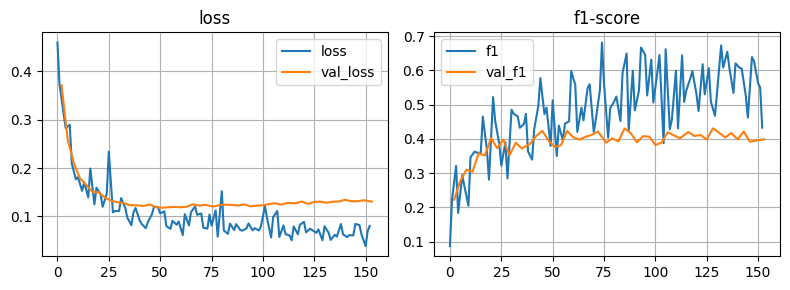

In [53]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_logs(df):
    fig = plt.figure(figsize=(8, 3))
    ax = fig.add_subplot(121)
    df.loss.dropna().plot(grid=True, title='loss', ax=ax)
    df.val_loss.dropna().plot(grid=True, ax=ax)
    ax.legend()
    ax = fig.add_subplot(122)
    df.f1.dropna().plot(grid=True, title='f1-score', ax=ax)
    df.val_f1.dropna().plot(grid=True, ax=ax)
    ax.legend()
    plt.tight_layout()
    plt.show()

df = pd.read_csv('logs/solar-panel-detection/version_0/metrics.csv')
plot_logs(df)

We can see clear signs of overfitting.

## Submission

Load your model

In [57]:
model = UNet(n_classes=ds.num_classes)
task = ImageSegmentation.load_from_checkpoint('checkpoints/unet-baseline-val_f1=0.4310.ckpt', model=model, num_classes=ds.num_classes)
task.hparams

"model":        UNet(
  (conv1): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
  )
  (conv2): Sequential(
    (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (1): Sequential(
      (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (2): Sequential(
      (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_r

Check on validation samples

In [58]:
from skimage import io
from skimage import transform

def clip(x, **kwargs):
    return np.clip(x, 0.0, 1.0).astype(np.float32)

def normalize(x, **kwargs):
    return x / 4000 

test_tans = A.Compose(
    [
        A.Resize(32, 32), # resize to 32x32 due to model architecture
        A.Lambda(image=normalize), 
        A.Lambda(image=clip), 
        ToTensorV2(),  
    ]
)

def generatre_mask(image, threshold= 0.4):
    task.eval()
    with torch.no_grad():
        # read image 
        image = io.imread(image)[...,(3,2,1)]
        size = image.shape[:2]
        # convert to tensor
        image_t = test_tans(image=image)['image']
        outputs = task(image_t.unsqueeze(0).to(task.device))
        mask = torch.sigmoid(outputs) > threshold
        mask = mask.long().squeeze().cpu().numpy()
        # resize to original size
        mask = transform.resize(mask, size, order=0, preserve_range=True).astype(np.uint8)
        return mask

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


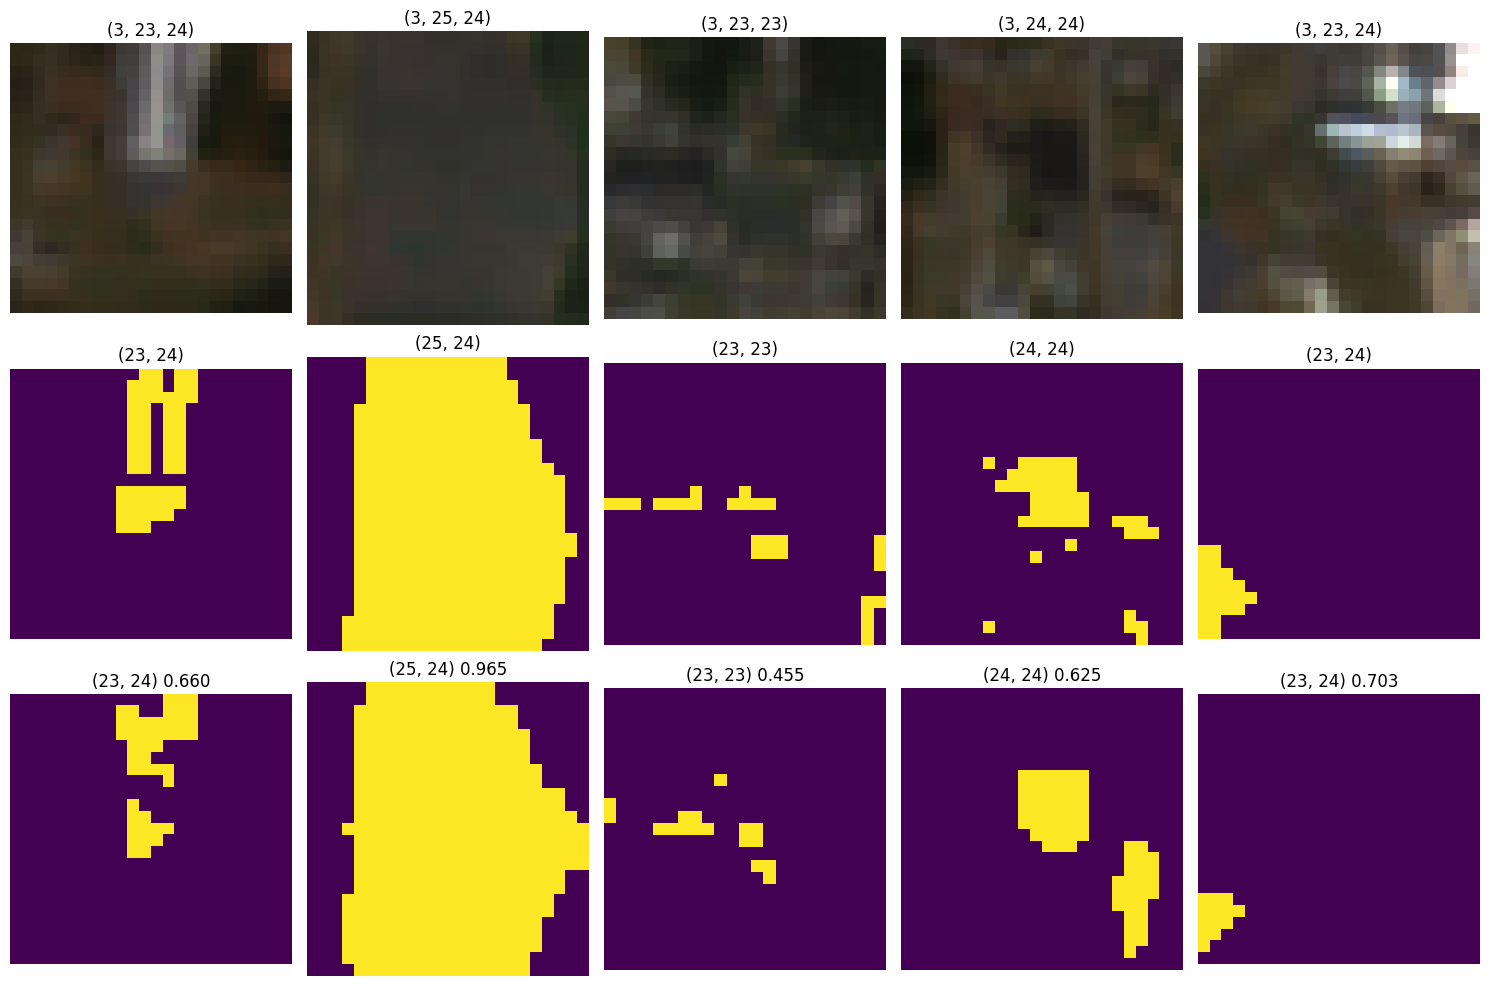

In [61]:
import matplotlib.pyplot as plt
import rasterio as rio 
from sklearn.metrics import f1_score

cols = 5
fig = plt.figure(figsize=(cols*3, 10))
for col in range(cols):
	image_path, mask_path = ds.val_df.sample().iloc[0]
	# image_path, mask_path = ds.train_df.iloc[col]
	ax1 = fig.add_subplot(3, cols, col+1)
	rgb = rio.open(image_path).read((4,3,2)) / 4000 
	ax1.imshow(rgb.transpose(1,2,0))
	ax1.axis('off')
	ax1.set_title(rgb.shape)
	ax2 = fig.add_subplot(3, cols, col+cols+1)
	mask = rio.open(mask_path).read(1)
	ax2.imshow(mask)
	ax2.axis('off')
	ax2.set_title(mask.shape)
	ax3 = fig.add_subplot(3, cols, col+2*cols+1)
	pred = generatre_mask(image_path)
	ax3.imshow(pred)
	ax3.axis('off')
	f1 = f1_score(mask.ravel(), pred.ravel())
	ax3.set_title(f'{mask.shape} {f1:.3f}')
plt.tight_layout()
plt.show()

For each image in the evaluation folder, generate corresponding mask and save it in the submission folder.

In [62]:
import os

os.makedirs('submission', exist_ok=True)

In [63]:
from tqdm import tqdm

for row in tqdm(ds.test_df.iterrows(), total=len(ds.test_df)):
    image, id = row[1]
    mask = generatre_mask(image)
    io.imsave(f'submission/evaluation_mask_{id}.tif', mask)


/tmp/ipykernel_56212/336198212.py:6: UserWarning: submission/evaluation_mask_851.tif is a low contrast image
  io.imsave(f'submission/evaluation_mask_{id}.tif', mask)
/tmp/ipykernel_56212/336198212.py:6: UserWarning: submission/evaluation_mask_1695.tif is a low contrast image
  io.imsave(f'submission/evaluation_mask_{id}.tif', mask)
/tmp/ipykernel_56212/336198212.py:6: UserWarning: submission/evaluation_mask_1204.tif is a low contrast image
  io.imsave(f'submission/evaluation_mask_{id}.tif', mask)
/tmp/ipykernel_56212/336198212.py:6: UserWarning: submission/evaluation_mask_1138.tif is a low contrast image
  io.imsave(f'submission/evaluation_mask_{id}.tif', mask)
/tmp/ipykernel_56212/336198212.py:6: UserWarning: submission/evaluation_mask_215.tif is a low contrast image
  io.imsave(f'submission/evaluation_mask_{id}.tif', mask)
/tmp/ipykernel_56212/336198212.py:6: UserWarning: submission/evaluation_mask_496.tif is a low contrast image
  io.imsave(f'submission/evaluation_mask_{id}.tif', m

Check outputs

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


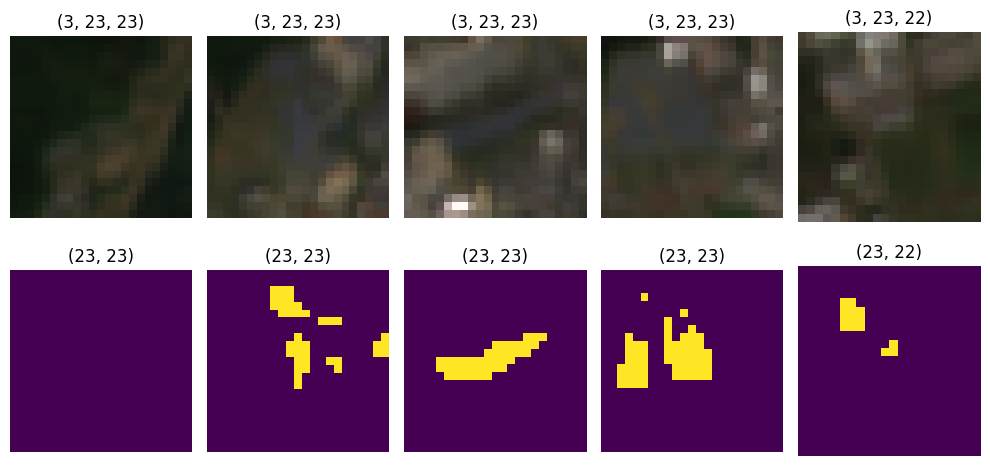

In [68]:
import matplotlib.pyplot as plt
import rasterio as rio 
import random

cols = 5
fig = plt.figure(figsize=(cols*2, 5))
for col in range(cols):
	image_path, image_id = ds.test_df.sample().iloc[0]
	ax1 = fig.add_subplot(2, cols, col+1)
	rgb = rio.open(image_path).read((4,3,2)) / 4000 
	ax1.imshow(rgb.transpose(1,2,0))
	ax1.axis('off')
	ax1.set_title(rgb.shape)
	ax2 = fig.add_subplot(2, cols, col+cols+1)
	mask_path = f'submission/evaluation_mask_{image_id}.tif'
	mask = rio.open(mask_path).read(1)
	ax2.imshow(mask)
	ax2.axis('off')
	ax2.set_title(mask.shape)
plt.tight_layout()
plt.show()

Create submission

In [71]:
assert len(os.listdir('submission')) == 2066, 'number of test images must be 2066'

!rm -rf submission.zip
!cd submission && zip -r ../submission.zip *

  adding: evaluation_mask_0.tif (deflated 81%)
  adding: evaluation_mask_1000.tif (deflated 82%)
  adding: evaluation_mask_1001.tif (deflated 82%)
  adding: evaluation_mask_1002.tif (deflated 79%)
  adding: evaluation_mask_1003.tif (deflated 81%)
  adding: evaluation_mask_1004.tif (deflated 78%)
  adding: evaluation_mask_1005.tif (deflated 79%)
  adding: evaluation_mask_1006.tif (deflated 83%)
  adding: evaluation_mask_1007.tif (deflated 83%)
  adding: evaluation_mask_1008.tif (deflated 83%)
  adding: evaluation_mask_1009.tif (deflated 83%)
  adding: evaluation_mask_100.tif (deflated 80%)
  adding: evaluation_mask_1010.tif (deflated 78%)
  adding: evaluation_mask_1011.tif (deflated 83%)
  adding: evaluation_mask_1012.tif (deflated 81%)
  adding: evaluation_mask_1013.tif (deflated 80%)
  adding: evaluation_mask_1014.tif (deflated 82%)
  adding: evaluation_mask_1015.tif (deflated 80%)
  adding: evaluation_mask_1016.tif (deflated 79%)
  adding: evaluation_mask_1017.tif (deflated 80%)
  ad

Due to the small size of this dataset you will probably get better results with other methods, but this is a good starting point if you choose to go with neural networks. One possible way to improve this baseline is to perform cross validation and ensemble the results.

I hope you like the library, we are planning to include more datasets and tasks in the future. If you find it useful please get in touch !!!